In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
import gc
da1 = np.load('embeddings_1.npy')
da2 = np.load('embeddings_2.npy')

In [2]:
da_all = np.vstack([da1,da2])
da_all.shape

(198982, 1024)

In [3]:
labels1 = pd.read_csv('icd_codes_1.txt',header = None)
labels1 = labels1[0].str.split(';')

In [4]:
labels2 = pd.read_csv('icd_codes_2.txt',header = None)
labels2 = labels2[0].str.split(';')

In [5]:
labels_all = pd.concat([labels1,labels2],axis = 0)

In [6]:
labels_all_tup = pd.Series([tuple(list) for list in labels_all])

In [7]:
data = pd.DataFrame(da_all)
data['Multilabels'] = labels_all_tup
data_uni = data.drop_duplicates(subset = data.columns[:-1],keep = False)

In [8]:
data_uni.shape

(195821, 1025)

In [9]:
labels_uni = data_uni['Multilabels']

In [10]:
def labels_in_cluster(cluster,labels_uni):
    '''
    cluster is a list of characters
    '''
    results = {}
    labels_all = [label for item in labels_uni for label in item]
    for cat in cluster:
        # print(set([label for label in labels_all if cat in label]))
        results[cat] = len(set([label for label in labels_all if cat in label]))
    return results
        

In [11]:
import string
alphabets = list(string.ascii_uppercase)
label_dist_true = labels_in_cluster(alphabets,labels_uni)
print(label_dist_true)

{'A': 128, 'B': 5, 'C': 47, 'D': 68, 'E': 25, 'F': 9, 'G': 32, 'H': 228, 'I': 11, 'J': 36, 'K': 131, 'L': 40, 'M': 360, 'N': 106, 'O': 2, 'P': 0, 'Q': 29, 'R': 58, 'S': 93, 'T': 25, 'U': 0, 'V': 1, 'W': 1, 'X': 48, 'Y': 1, 'Z': 90}


In [12]:
data_uni.iloc[:,:-1].shape

(195821, 1024)

In [13]:
data_uni.iloc[:,-1].shape

(195821,)

In [14]:
mlb = MultiLabelBinarizer()
X = data_uni.iloc[:,:-1]
y = pd.DataFrame(mlb.fit_transform(data_uni.iloc[:,-1]))

In [23]:
data_uni.iloc[:,-1]

1                                      (G89.29, M25.562)
2                (R13.10, K20.90, K31.89, K25.9, K29.80)
3              (K20.90, R10.11, Z86.010, K57.30, Z90.49)
4                 (R93.3, K29.50, R10.84, K31.89, R19.7)
5                                  (K62.5, K64.8, K64.5)
                               ...                      
198977    (K62.1, K64.8, Z86.010, Z12.11, K57.30, K63.5)
198978                   (Z12.11, Z86.010, K63.5, K64.8)
198979           (K62.1, K64.8, Z86.010, Z12.11, K57.30)
198980                                  (K20.90, K29.70)
198981                           (K63.5, K57.30, K63.89)
Name: Multilabels, Length: 195821, dtype: object

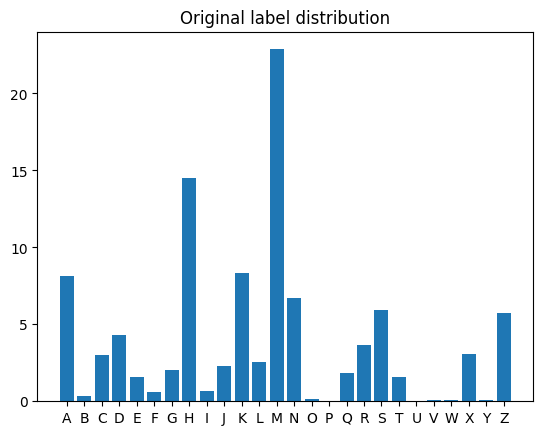

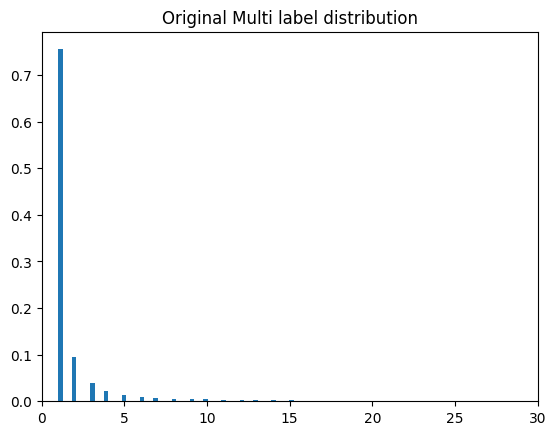

0it [00:00, ?it/s]

('G89.29', 'M25.562')


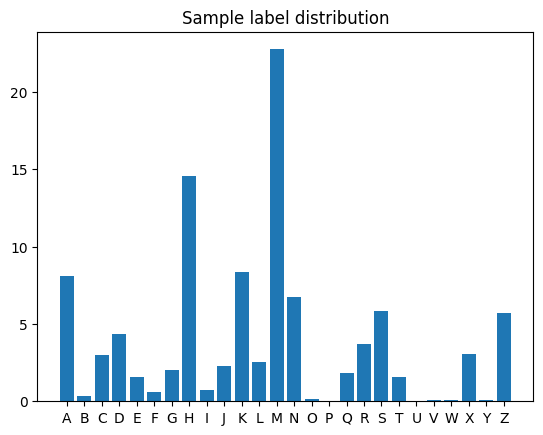

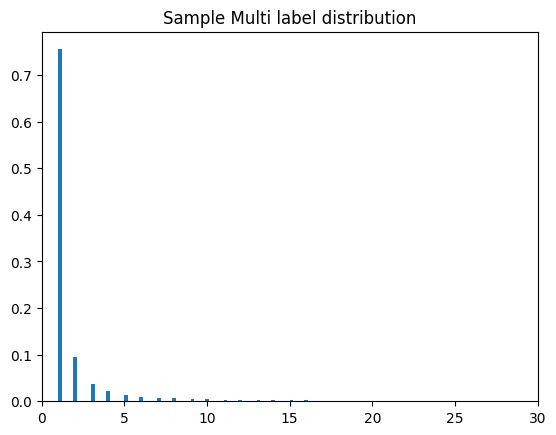

0it [01:00, ?it/s]


In [28]:
# Collecting a sample of data for testing out models
from skmultilearn.model_selection import IterativeStratification
from collections import Counter
# Initialize the stratifier
stratifier = IterativeStratification(n_splits=5, order=1)

#Need to check whether the original multilabel distribution is maintained
plt.figure(0)
alphas = label_dist_true.keys()
percents = np.fromiter(label_dist_true.values(),dtype = 'float32')
# print(percents)
percents = percents*100/np.sum(percents)
plt.bar(alphas,percents)
plt.title('Original label distribution')
plt.show()
#Need to check individual label is fixed
clustering_count = Counter()
for ml in labels_uni:
    clustering_count[ml] +=1

plt.figure(1)
plt.hist(clustering_count.values(),weights=np.ones(len(clustering_count.values())) / len(clustering_count.values()),bins = 10000)
plt.title('Original Multi label distribution')
plt.xlim(0,30)
plt.show()

# Split your dataset
# print(stratifier.split(data_uni.iloc[:,:-1], data_uni.iloc[:,-1]))
for train_indices,test_indices in tqdm(stratifier.split(X,y)):
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test =X.iloc[test_indices], y.iloc[test_indices]
    y_train_labels = mlb.inverse_transform(np.array(y_train))
    # print(y_train_labels[0])
    label_dist_sample = labels_in_cluster(alphabets,y_train_labels)
    plt.figure(0)
    alphas = label_dist_sample.keys()
    percents = np.fromiter(label_dist_sample.values(),dtype = 'float32')
    percents = percents*100/np.sum(percents)
    plt.bar(alphas,percents)
    plt.title('Sample label distribution')
    plt.show()
    #Need to check individual label is fixed
    clustering_count = Counter()
    for ml in y_train_labels:
        # print(ml)
        clustering_count[ml] +=1
    # print(clustering_count)
    
    plt.figure(1)
    plt.hist(clustering_count.values(),weights=np.ones(len(clustering_count.values())) / len(clustering_count.values()),bins = 10000)
    plt.title('Sample Multi label distribution')
    plt.xlim(0,30)
    plt.show()


In [78]:
gc.collect()

0